# Pokemon GAN Training Notebook

## **Import libraries**

dcgan_pokemon_train_1: label_smoothing: False <br>
dcgan_pokemon_train_2: label_smoothing: True <br>
dcgan_pokemon_train_3: label_smoothing: False <br>
dcgan_pokemon_train_4: label_smoothing: True <br>
dcgan_pokemon_train_5: label_smoothing: False <br>
dcgan_pokemon_train_6: label_smoothing: True <br>
dcgan_pokemon_train_7: label_smoothing: False <br>
dcgan_pokemon_train_8: label_smoothing: True <br>

In [1]:
import sys
sys.path.append('../sources')

In [2]:
import pandas as pd
import numpy as np
import torch
import utils as ut
import variable as var
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from DCGAN import DCGAN
import cuda_monitoring as cuda_mon

In [3]:
import torchvision.utils as vutils

In [4]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 5.73 GB
used     : 2.05 GB	(35.73%)


## **Load DATASET**

In [23]:
resume_training = True
train_number = 'n_feature_16' #normal_weight_init
gan_id = f"dcgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 64
normalize_input = 'min_max_scale'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [24]:
dset = PokemonGensDataset(greyscale=greyscale, normalize=normalize_input,
                          resize=[resize_image_dim, resize_image_dim],
                          gens_to_remove=("gen8", "gen7", "gen6", 'gen1'))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'dataset: {len(dset)} images')

dataset: 4244 images


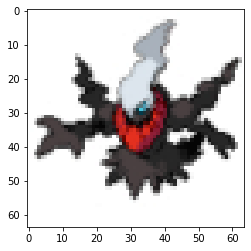

In [25]:
images, labels = next(iter(dloader))
ut.show_images_grid(images, 1)

## **GAN Component**

In [27]:
gen_lr = 1e-3
disc_lr = 1e-3
beta1 = .9
beta2 = .999
betas = {'1': beta1, '2': beta2}
n_channel = 1 if greyscale else 3
n_feature = 16
z_dim = 60
use_inception = True
label_smoothing = True
generator_type = 'convtranspose'

    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': betas},
          'disc': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': disc_lr,
                   'betas': betas},
          'output_size': resize_image_dim,
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'dataset': dset.describe(),
          'batch_size': batch_size,
          'label_smoothing': label_smoothing,
          'use_inception': use_inception,
          'generator_type': generator_type,
          'noise_distrib': 'gaussian'
         }

## **GAN INIT AND TRAINING**

In [28]:
gan = DCGAN(params, normal_weight_init=True)
checkpoint_path = os.path.join(var.PROJECT_DIR, f'data/models/{gan_id}.pth')
if os.path.exists(checkpoint_path):
    print('RESUMING TRAINING...')
    gan.load_model(checkpoint_path)
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

RESUMING TRAINING...
id: dcgan_pokemon_train_n_feature_16


In [29]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [30]:
gan.train(n_epoch=3, dataloader=dloader, gan_id=gan_id)

100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


## **RESULT VIZUALIZATION**

0.4285416305065155


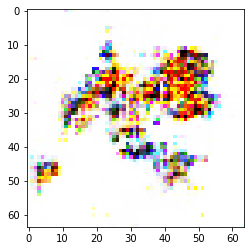

In [27]:
n = 1
noise = gan.get_random_noise(n)
with torch.no_grad():
    fakes = gan.generator(noise)
print(torch.nn.Sigmoid()(gan.discriminator(fakes)[:n]).item())
ut.show_images_grid(fakes)

In [13]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(1.0946, device='cuda:0'), tensor(0.6593, device='cuda:0'), tensor(0.6367, device='cuda:0'), tensor(1.0211, device='cuda:0'), tensor(0.6921, device='cuda:0'), tensor(1.3243, device='cuda:0'), tensor(0.5580, device='cuda:0'), tensor(1.8684, device='cuda:0'), tensor(0.6073, device='cuda:0')]


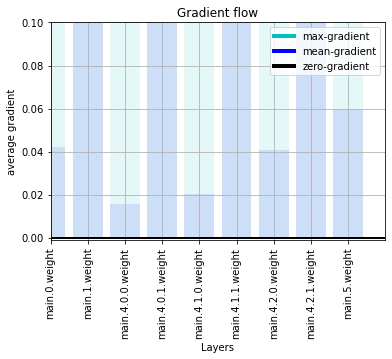

In [40]:
plot_grad_flow(gan.generator.named_parameters())

In [20]:
if False:
    ut.delete_gans_id(gan_id)

In [12]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(var.device),
                  torch.zeros(xx.shape).to(var.device),
                  torch.zeros(xx.shape).to(var.device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)


In [13]:
real_1 = next(iter(dloader))[0].reshape(64, -1).to(var.device)
real_2 = next(iter(dloader))[0].reshape(64, -1).to(var.device)
fake_1 = gan.generate_fake(64, train=False).reshape(64, -1)
fake_2 = gan.generate_fake(64, train=False).reshape(64, -1)

In [20]:
MMD(real_2, fake_1, "rbf")

tensor(4.0611, device='cuda:0')

tensor([[[[ 0.2095]],

         [[ 0.6231]],

         [[ 0.1341]],

         ...,

         [[-0.6994]],

         [[ 0.3988]],

         [[-0.3985]]],


        [[[-0.2500]],

         [[-0.6695]],

         [[ 0.6322]],

         ...,

         [[ 0.9828]],

         [[ 0.6312]],

         [[ 0.9429]]],


        [[[-0.2352]],

         [[-0.7346]],

         [[-0.8679]],

         ...,

         [[-0.5183]],

         [[ 0.2686]],

         [[ 0.4509]]],


        ...,


        [[[ 0.5306]],

         [[-0.8427]],

         [[-0.8874]],

         ...,

         [[-0.8960]],

         [[-0.6557]],

         [[ 0.9227]]],


        [[[ 0.6746]],

         [[ 0.7623]],

         [[ 0.0314]],

         ...,

         [[ 0.7947]],

         [[-0.5600]],

         [[-0.6985]]],


        [[[-0.7437]],

         [[ 0.1520]],

         [[ 0.7761]],

         ...,

         [[-0.3378]],

         [[-0.8125]],

         [[-0.0864]]]])